#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Big Data**
###Tecnológico de Monterrey
###Prof Iván Olmos Pineda

### **Actividad de la Semana 8**
###**Métricas de calidad de resultados**

**Nombre y matrícula:**

*   César Armando Prieto Siller
*   A01796382


# **Selección de los datos**

## **Descripción de la Base de datos**

Base de datos seleccionada: IBM Transactions for Anti-Money Laundering (AML), versión LI-Medium

La base de datos está compuesta por aproximadamente 31 millones de transacciones, contiene una menor proporción de casos positivos de lavado de dinero respecto a las otras versiones.

Se cuenta con información como: momento de la transacción, bancos y cuentas involucradas, montos ($) y monedas, formato y si la transacción se considera o no lavado de dinero.

## **Descripción de las reglas de particionamiento**

Variables de caracterización seleccionadas: Payment Currency y Payment Format.

Agrupación previa al particionamiento:
Payment Format:
* Online: ACH, Credit Card, Wire y Bitcoin
* Offline: Cheque, Cash y Reinvestment

Payment Currency:
* America: MXN, USD, BRL y CAD
* Others: se excluyen las monedas antes listadas

Reglas:
* *Part 1*: Payment Format = Online & Payment Currency = America
* *Part 2*: Payment Format = Online & Payment Currency = Others
* *Part 3*: Payment Format = Offline & Payment Currency = America
* *Part 4*: Payment Format = Offline & Payment Currency = Others

## **Cargando el entorno de PySpark en Google Colab**

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [27]:
!ls

drive	     spark-3.1.1-bin-hadoop3.2	    spark-3.1.1-bin-hadoop3.2.tgz.1
sample_data  spark-3.1.1-bin-hadoop3.2.tgz


In [4]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("Actividad4") \
                    .config("spark.driver.memory", "8g") \
                    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark
spark

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import count, when, isnan, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, min, max

from pyspark.ml.feature import StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [7]:
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/MNA/TC4034.10 Big Data/Tareas/S3/LI-Medium_Trans.csv",
                    header=True, sep=",", inferSchema=True)

# **1. Construcción de la muestra M**

In [8]:
Payment_Format_Online = ["ACH","Credit Card","Wire","Bitcoin"]
Payment_Format_Offline = ["Cheque","Cash","Reinvestment"]

Payment_Currency_America = ["Mexican Peso", "US Dollar", "Brazil Real", "Canadian Dollar"]
Payment_Currency_Others = ["Yen", "UK Pound", "Australian Dollar","Saudi Riyal", "Shekel","Yuan","Euro","Rupee","Swiss Franc","Bitcoin","Ruble"]

In [9]:
from pyspark.sql.functions import col

# Payment Format = Online y Payment Currency = America
part_1 = df.filter((col("Payment Format").isin(Payment_Format_Online)) & (col("Payment Currency").isin(Payment_Currency_America)))
print("Partición 1: Online y America")
part_1.show()

# Payment Format = Online y Payment Currency = Others
part_2 = df.filter((col("Payment Format").isin(Payment_Format_Online)) & (col("Payment Currency").isin(Payment_Currency_Others)))
print("Partición 2: Online y Resto del Mundo")
part_2.show()

# Payment Format = Offline y Payment Currency = America
part_3 = df.filter((col("Payment Format").isin(Payment_Format_Offline)) & (col("Payment Currency").isin(Payment_Currency_America)))
print("Partición 3: Offline y America")
part_3.show()

# Payment Format = Offline y Payment Currency = Others
part_4 = df.filter((col("Payment Format").isin(Payment_Format_Offline)) & (col("Payment Currency").isin(Payment_Currency_Others)))
print("Partición 4: Offline y Resto del Mundo")
part_4.show()


# Verificación de Submuestras
count_part_1 = part_1.count()
print(f"Número de filas en part_1: {count_part_1}")

count_part_2 = part_2.count()
print(f"Número de filas en part_2: {count_part_2}")

count_part_3 = part_3.count()
print(f"Número de filas en part_3: {count_part_3}")

count_part_4 = part_4.count()
print(f"Número de filas en part_4: {count_part_4}")

Partición 1: Online y America
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|       20|80010E6F0|  27365|8084250A0|         137.72|         US Dollar|     137.72|       US Dollar|   Credit Card|            0|
|2022/09/01 00:05|       20|80010EA30|  18234|82BC4CE30|           1.24|         US Dollar|       1.24|       US Dollar|   Credit Card|            0|
|2022/09/01 00:21|       11|8003289F0| 237264|810BA3240|           5.28|         US Dollar|       5.28|       US Dollar|   Credit Card|            0|
|2022/09/01 00:11|     2776|800816450|1190218|8486D8D10|          13.2

## **Submuestreo**

In [10]:
from pyspark.sql.functions import rand

fraccion_de_muestra = 0.2

# 'False' = el muestreo se realiza sin reemplazo.
submuestra_M1 = part_1.sample(False, fraccion_de_muestra, seed=123)  # seed para reproducibilidad

submuestra_M1.show()

tamaño_submuestra_1 = submuestra_M1.count()
print("Tamaño de la submuestra para Online y America:", tamaño_submuestra_1)

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|       20|80010E6F0|  27365|8084250A0|         137.72|         US Dollar|     137.72|       US Dollar|   Credit Card|            0|
|2022/09/01 00:26|     1601|800970C80|  26669|80EE08950|         133.98|         US Dollar|     133.98|       US Dollar|   Credit Card|            0|
|2022/09/01 00:19|     1924|800AD8140|  17200|83F5A3DD0|         250.23|         US Dollar|     250.23|       US Dollar|   Credit Card|            0|
|2022/09/01 00:01|      741|800ADCDB0| 234135|80FA463E0|           7.64|         US Dollar|       7.

In [11]:
submuestra_M2 = part_2.sample(False, fraccion_de_muestra, seed=123)
submuestra_M2.show()
tamaño_submuestra_2 = submuestra_M2.count()
print("Tamaño de la submuestra para Online y Resto del Mundo:", tamaño_submuestra_2)

+----------------+---------+---------+-------+---------+---------------+------------------+--------------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|   Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+--------------+----------------+--------------+-------------+
|2022/09/01 00:11|    27669|8043475E0| 119043|824C90D30|           5.82|              Euro|          5.82|            Euro|   Credit Card|            0|
|2022/09/01 00:25|     1601|800F66E21|   2589|801352771|       0.150633|           Bitcoin|      0.150633|         Bitcoin|       Bitcoin|            0|
|2022/09/01 00:06|    18328|8041E5C70| 292826|82BCBA740|          35.21|              Euro|         35.21|            Euro|   Credit Card|            0|
|2022/09/01 00:14|     1831|8011ED901| 113503|805B64B21|       3.425702|          

In [12]:
submuestra_M3 = part_3.sample(False, fraccion_de_muestra, seed=123)
submuestra_M3.show()
tamaño_submuestra_3 = submuestra_M3.count()
print("Tamaño de la submuestra para Offline y America:", tamaño_submuestra_3)

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|       20|800104D70|     20|800104D70|        8095.07|         US Dollar|    8095.07|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:27|       20|800104D20|     20|800104D20|           9.72|         US Dollar|       9.72|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:22|     1924|8009B6B00|   1924|8009B6B00|        1704.89|         US Dollar|    1704.89|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:22|       20|800AD58D0|     20|800AD58D0|     1573418.17|         US Dollar| 1573418.

In [13]:
submuestra_M4 = part_4.sample(False, fraccion_de_muestra, seed=123)
submuestra_M4.show()
tamaño_submuestra_4 = submuestra_M4.count()
print("Tamaño de la submuestra para Offline y Resto del Mundo:", tamaño_submuestra_4)

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+-----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid| Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+-----------------+--------------+-------------+
|2022/09/01 00:21|    33605|80251F890|  33605|80251F890|      131510.97|              Yuan|  131510.97|             Yuan|  Reinvestment|            0|
|2022/09/01 00:07|    36214|807585840|  36214|807585840|       37746.85|              Yuan|   37746.85|             Yuan|  Reinvestment|            0|
|2022/09/01 00:01|   343558|8109A96A0| 343558|8109A96A0|        30278.1|             Rupee|    30278.1|            Rupee|  Reinvestment|            0|
|2022/09/01 00:22|   316869|815DFF590| 316869|815DFF590|         351.67|              Euro|   

## **Preparación de los datos**


In [14]:
# Unificar las submuestras
muestra_combinada_M = submuestra_M1.union(submuestra_M2).union(submuestra_M3).union(submuestra_M4)

print("Esquema de la muestra combinada:")
muestra_combinada_M.printSchema()

print("Primeras filas de la muestra combinada:")
muestra_combinada_M.show(5)

# Identificación de valores nulos
print("Conteo de valores nulos por columna:")
muestra_combinada_M.select([count(when(col(c).isNull(), c)).alias(c) for c in muestra_combinada_M.columns]).show()


# Identificación de valores atípicos (outliers)
print("Estadísticas descriptivas para columnas numéricas:")
muestra_combinada_M.select("Amount Paid").summary().show()
muestra_combinada_M.select("Payment Currency").summary().show()




Esquema de la muestra combinada:
root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: double (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)

Primeras filas de la muestra combinada:
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+---

Con el código anterior podemos darnos cuenta de que no hay valores nulos en el dataset, lo que hace sentido ya que es una colección de registros bancarios.
Existen muchos valores atípicos para la columna de "Amount Paid", por lo que se realizará escalamiento en el preprocesamiento.

In [15]:
# Obtener el número de filas y columnas en muestra_combinada
filas_muestra_combinada = muestra_combinada_M.count()
cols_muestra_combinada = len(muestra_combinada_M.columns)

column_names = muestra_combinada_M.columns
print(f"El tamaño de muestra_combinada es: {filas_muestra_combinada}")
print(f"El número de columnas en muestra_combinada es: {cols_muestra_combinada}")
print("Nombres de las columnas:")
for col_name in column_names:
    print(col_name)

El tamaño de muestra_combinada es: 6253899
El número de columnas en muestra_combinada es: 11
Nombres de las columnas:
Timestamp
From Bank
Account2
To Bank
Account4
Amount Received
Receiving Currency
Amount Paid
Payment Currency
Payment Format
Is Laundering


In [16]:
# Pasos de preprocesamiento
# Se escala "Amount Paid" utilizando primero VectorAssembler para vectorizar la columna y después StandardScaler,
# utilizando la desviación estándar
assembler_amount = VectorAssembler(inputCols=["Amount Paid"], outputCol="amount_vector")
scaler = StandardScaler(inputCol="amount_vector", outputCol="scaled_amount", withStd=True, withMean=False)

# Se codifican "Payment Currency" y "Payment Format" con One Hot Encoding ya que son variables categóricas
# Primero se utiliza StringIndexer para convertir las categorías en índices numéricos.
indexer_currency = StringIndexer(inputCol="Payment Currency", outputCol="currency_index")
indexer_format = StringIndexer(inputCol="Payment Format", outputCol="format_index")
# Después, se aplica el OneHotEncoder para convertir los índices en vectores codificados
encoder_currency = OneHotEncoder(inputCol="currency_index", outputCol="currency_encoded")
encoder_format = OneHotEncoder(inputCol="format_index", outputCol="format_encoded")


# Se combinan todas las características en un solo vector, como lo requieren los algoritmos de PySpark

feature_assembler = VectorAssembler(
    inputCols=["scaled_amount", "currency_encoded", "format_encoded"],
    outputCol="features_final"
)

# Se crea el Pipeline que incluirá todos los pasos de transformación definidos previamente.
preprocessing_pipeline = Pipeline(stages=[
    assembler_amount,
    scaler,
    indexer_currency,
    indexer_format,
    encoder_currency,
    encoder_format,
    feature_assembler
])

# Se utiliza el pipeline para entrenar y transformar los datos
pipeline_model = preprocessing_pipeline.fit(muestra_combinada_M)

muestra_combinada_processed = pipeline_model.transform(muestra_combinada_M)


# Revisamos el esquema con las columnas incluidas, así como las primeras líneas del DataFrame
print("Schema of the processed DataFrame:")
muestra_combinada_processed.printSchema()

print("First 5 rows of the processed DataFrame:")
muestra_combinada_processed.select("Amount Paid", "scaled_amount", "Payment Currency", "currency_index", "currency_encoded", "Payment Format", "format_index", "format_encoded", "features_final", "Is Laundering").show(5, truncate=False)


Schema of the processed DataFrame:
root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: double (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)
 |-- amount_vector: vector (nullable = true)
 |-- scaled_amount: vector (nullable = true)
 |-- currency_index: double (nullable = false)
 |-- format_index: double (nullable = false)
 |-- currency_encoded: vector (nullable = true)
 |-- format_encoded: vector (nullable = true)
 |-- features_final: vector (nullable = true)

First 5 rows of the processed DataFrame:
+-----------+-----------------------+----------------+--------------+----------------+--------------+------------

# **2. Construcción Train – Test**

In [17]:
# Después del preprocesamiento, se realiza la división de entrenamiento y prueba
# Se agrega la semilla para asegurar repetibilidad

training_ratio = 0.8
testing_ratio = 1 - training_ratio
train_data_processed, test_data_processed = muestra_combinada_processed.randomSplit([training_ratio, testing_ratio], seed=42)

In [41]:
# Se revisa la cantidad de renglones y columnas de cada conjunto de datos
print(f"Número de filas en el conjunto de entrenamiento: {train_data_processed.count()}")
print(f"Número de filas en el conjunto de prueba: {test_data_processed.count()}")
print(f"Número de columnas en el conjunto de entrenamiento: {len(train_data_processed.columns)}")
print(f"Número de columnas en el conjunto de prueba: {len(test_data_processed.columns)}")




Número de filas en el conjunto de entrenamiento: 5002442
Número de filas en el conjunto de prueba: 1251457
Número de columnas en el conjunto de entrenamiento: 18
Número de columnas en el conjunto de prueba: 18


# **3. Selección de métricas para medir calidad de resultado**

Métricas para el modelo de regresión logística:

*   Recall (Sensibilidad): Establece la relación entre los datos
verdaderamente positivos y los datos positivos totales. Para el tema de detección de lavado de dinero, un alto recall es importante para minimizar los falsos negativos (transacciones de lavado de dinero que el modelo no detectó). VP/(VP+FN)
*   Precisión: Establece la relación entre los datos verdaderamente positivos y el total de datos clasificados como positivos. Un alta precisión indica que cuando el modelo predice que una transacción es lavado de dinero, es muy probable que lo sea. Es importante equilibrar Precision y Recall, especialmente en casos de desbalance. VP(VP+FP)
*   F1-Score: Es la media armónica de Precision y Recall. Proporciona un equilibrio entre ambas métricas y es útil cuando buscas un balance entre identificar todos los positivos posibles y no tener demasiados falsos positivos.
*   Matriz de Confusión: Es la tabla que  muestra la cantidad de Verdaderos Positivos (TP), Verdaderos Negativos (TN), Falsos Positivos (FP) y Falsos Negativos (FN). Esto nos ayudará a ver  dónde está fallando el modelo .
*   Área bajo la curva Precision-Recall. es una excelente elección para conjuntos de datos desbalanceados. Se enfoca en el rendimiento del modelo en la clase positiva (la clase minoritaria - lavado de dinero). Un área bajo la curva PR alta indica que el modelo es capaz de identificar correctamente los casos positivos sin generar demasiados falsos positivos.


Métricas para el modelo de K-Means:

*   Coeficiente de Silhouette: Se utiliza para evaluar la calidad de los clusters. Mide qué tan similar es un objeto a su propio cluster (cohesión) en comparación con otros clusters (separación). Un valor cercano a 1 indica que el objeto está bien agrupado, un valor cercano a 0 indica que está cerca del límite entre dos clusters, y un valor negativo indica que el objeto podría estar en el cluster equivocado. Un score promedio de Silhouette más alto indica un mejor clustering.

*   Within-Cluster Sum of Squares (WCSS) ("trainingCost" en PySpark):
Mide la suma de los cuadrados de las distancias de cada punto a su centroide dentro de cada cluster. Un menor WCSS generalmente indica clusters más compactos. Se puede usar WCSS para determinar el número óptimo de clusters.


# **4. Entrenamiento de Modelos de Aprendizaje**


In [18]:
# Se definen los modelos a utilizar y se entrena utilizando los conjuntos de datos del paso anterior
# Se elige regresión logística porque la variable a predecir es categórica

target_col= "Is Laundering"

lr = LogisticRegression(labelCol=target_col, featuresCol="features_final")
lr_model = lr.fit(train_data_processed)
predictions = lr_model.transform(test_data_processed)


In [19]:
# Se crea una cuadrícula de hiperparámetros para probar
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .addGrid(lr.maxIter, [10, 20]) \
    .build()

# Se elige la máetrica de area bajo la curva PR para evaluar los parámetros
evaluator = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="rawPrediction", metricName="areaUnderPR")

# Configura CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5) # Define el número de folds para validación cruzada

# Ejecuta la validación cruzada para encontrar el mejor modelo
cvModel = cv.fit(train_data_processed)

# Obtén el mejor modelo
best_lr_model = cvModel.bestModel

# Ahora puedes usar best_lr_model para hacer predicciones en el conjunto de prueba
predictions = best_lr_model.transform(test_data_processed)

# Evalúa el mejor modelo
areaUnderPR_best = evaluator.evaluate(predictions)
print(f"Mejor Área bajo la curva PR: {areaUnderPR_best}")

Mejor Área bajo la curva PR: 0.003098651787642625


In [20]:
# Impresión del mejor modelo
print(best_lr_model)
print(best_lr_model.extractParamMap())

LogisticRegressionModel: uid=LogisticRegression_ba6395d765db, numClasses=2, numFeatures=21
{Param(parent='LogisticRegression_ba6395d765db', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_ba6395d765db', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_ba6395d765db', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_ba6395d765db', name='featuresCol', doc='features column name.'): 'features_final', Param(parent='LogisticRegression_ba6395d765db', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_ba6395d765db', name='labelCol', doc='label column name.'): 'Is Laundering', Param

In [44]:
# Se muestran las predicciones realizadas incluyendo las columnas agregadas
predictions.select("features_final", "Is Laundering", "rawPrediction",
                   "prediction", "probability").show(5)


+--------------------+-------------+--------------------+----------+--------------------+
|      features_final|Is Laundering|       rawPrediction|prediction|         probability|
+--------------------+-------------+--------------------+----------+--------------------+
|(21,[0,1,16],[7.9...|            0|[7.59569830219422...|       0.0|[0.99949764362751...|
|(21,[0,1,16],[8.2...|            0|[7.59569830220942...|       0.0|[0.99949764362752...|
|(21,[0,5,17],[4.2...|            0|[7.56245100079558...|       0.0|[0.99948066970257...|
|(21,[0,1,16],[1.5...|            0|[7.59569830188097...|       0.0|[0.99949764362735...|
|(21,[0,5,16],[6.5...|            0|[7.59585738492404...|       0.0|[0.99949772349724...|
+--------------------+-------------+--------------------+----------+--------------------+
only showing top 5 rows



In [45]:
# Se crean evaluadores para revisar las métrica de Área bajo la curva Precision-Recall,
# F1-Score y recall
evaluator = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="rawPrediction",
                                          metricName="areaUnderPR")

areaUnderPR = evaluator.evaluate(predictions)

f1_score=MulticlassClassificationEvaluator(labelCol=target_col,
                                      predictionCol="prediction", metricName="f1").evaluate(predictions)

recall=MulticlassClassificationEvaluator(labelCol=target_col,
                                      predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)

precision=MulticlassClassificationEvaluator(labelCol=target_col,
                                      predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)

print(f"Area bajo la curva PR del modelo de regresión logística: {areaUnderPR}")
print(f"F1 Score del modelo de regresión logística: {f1_score}")
print(f"Recall del modelo de regresión logística: {recall}")
print(f"Precision del modelo de regresión logística: {precision}")



Area bajo la curva PR del modelo de regresión logística: 0.0030924759496830058
F1 Score del modelo de regresión logística: 0.999261721194979
Recall del modelo de regresión logística: 0.9995077737389299
Precision del modelo de regresión logística: 0.9990157897645519


In [47]:
# Se calculan los verdaderos y falsos, tanto positivos como negativos para formar la Matriz de confusión
tp = predictions.filter((predictions['Is Laundering'] == 1) & (predictions['prediction'] == 1)).count()
fp = predictions.filter((predictions['Is Laundering'] == 0) & (predictions['prediction'] == 1)).count()
tn = predictions.filter((predictions['Is Laundering'] == 0) & (predictions['prediction'] == 0)).count()
fn = predictions.filter((predictions['Is Laundering'] == 1) & (predictions['prediction'] == 0)).count()

print(f"Verdaderos Positivos (TP): {tp}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Negativos (FN): {fn}")

Verdaderos Positivos (TP): 0
Falsos Positivos (FP): 0
Verdaderos Negativos (TN): 1250841
Falsos Negativos (FN): 616


In [21]:
# Algoritmo aprendizaje automático no supervisado, K-Means
# Se utiliza la métrica WCSS para comparar la distancia de los centroides de cada cluster

K = 7
kmeans = KMeans().setK(K).setSeed(1).setFeaturesCol("features_final")
kmeans_model = kmeans.fit(train_data_processed)
predictions_clustering = kmeans_model.transform(train_data_processed)
wcss = kmeans_model.summary.trainingCost
print(f"WCSS para el K-means de las características procesadas: {wcss}")

# Métrica Silhouette para evaluar la calidad de los clústers.
evaluator_silhouette = ClusteringEvaluator(
    featuresCol="features_final",
    predictionCol="prediction",
    metricName="silhouette" # Especificamos la métrica Silhouette
)

# Calcula el Coeficiente de Silhouette
silhouette_score = evaluator_silhouette.evaluate(predictions_clustering)

print(f"Métrica de Silhouette para K means (K={K}): {silhouette_score}")


WCSS para el K-means de las características procesadas: 4811869.499913768
Métrica de Silhouette para K means (K=7): 0.3935521674498104


In [48]:
# Rango de valores de K a probar
k_values = range(6,7)

# Lista para almacenar los resultados de las métricas
silhouette_scores = []
wcss_scores = []

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features_final")
    kmeans_model = kmeans.fit(train_data_processed)
    predictions_clustering = kmeans_model.transform(train_data_processed)

    # Calcular WCSS
    wcss = kmeans_model.summary.trainingCost
    wcss_scores.append(wcss)

    # Calcular Coeficiente de Silhouette
    evaluator_silhouette = ClusteringEvaluator(
        featuresCol="features_final",
        predictionCol="prediction",
        metricName="silhouette"
    )
    silhouette_score = evaluator_silhouette.evaluate(predictions_clustering)
    silhouette_scores.append(silhouette_score)

    print(f"K={k}, WCSS: {wcss}, Silhouette Score: {silhouette_score}")

# Graficar WCSS para el método del codo
plt.plot(k_values, wcss_scores, marker='o')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("WCSS")
plt.title("Método del Codo para determinar K óptimo")
plt.show()

# Graficar Silhouette Scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score para determinar K óptimo")
plt.show()

K=4, WCSS: 6339420.795419271, Silhouette Score: 0.3079882550966626
K=5, WCSS: 6079070.240929412, Silhouette Score: 0.39553290618809117
K=6, WCSS: 5226608.105524405, Silhouette Score: 0.4299405291757521


KeyboardInterrupt: 

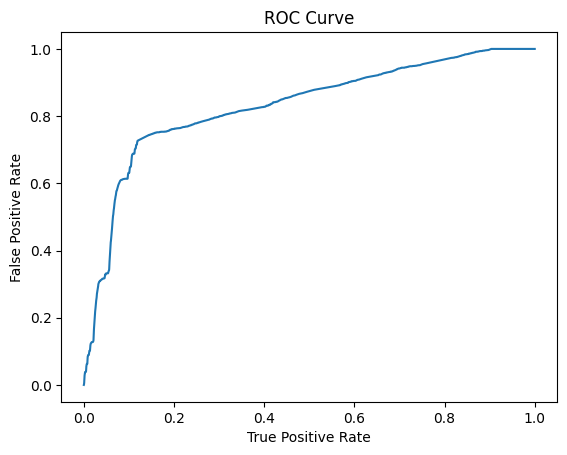

Training set areaUnderROC: 0.829868090276063


In [22]:
# Imprimiendo la curva ROC
import matplotlib.pyplot as plt

trainingSummary = lr_model.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

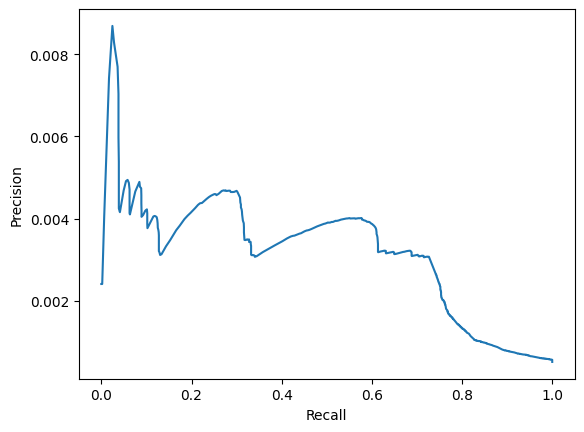

In [23]:
# Imprimiendo la curva entre Precision y Recall

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# **5. Análisis de resultados**

Las métricas del F1-Score y Recall salieron muy altas, lo que podría indicar sobreentrenamiento en el modelo ya que tenemos datos desbalanceados en la variable objetivo ("Is Laundering").

El área bajo la curva PR es demasiado bajo, lo que nos indica que el modelo tiene un rendimiento casi nulo para identificar las transacciones de lavado de dinero.

La métrica de WCSS nos ayuda a analizar la distancia de los centros de los clústeres para identificar la cantidad de clústers "K" óptima para nuestro modelo. Se pueden ir aumentando la cantidad de K y revisando contra el valor de WCSS hasta que la diferencia entre agregar un clúster o no sea mínima.

La métrica de Silhouette 0.4299 nos indica que el clustering podría no ser muy robusto, ya sea porque las agrupaciones de datos están muy cerca unos de otros o que el conjunto de datos en general no se preste a utilizar este tipo de algoritmos. Se encontró que K = 7 da un mejor resultado.
Lo ideal es que el valor de la métrica se encuentre entre 0.7 y 1.
